# 5.2 LSTM and GRU

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

In [1]:
%matplotlib inline

## U5.02 - Long Short Term Memory RNN

The main drawback of conventional RNNs is its inability to learn long term dependency, or even the capacity of capturing long and short dependences at the same time.

Remenber that in a RNN:

$${\bf{a}}^{(t)} = {\bf{b}} + {\bf{V}}{\bf{h}}^{(t-1)} + {\bf{U}}{\bf{x}}^{(t)},\\ {\bf{h}}^{(t)} = \tanh({\bf{a}}^{(t)}), \\ {\bf{o}}^{(t)} = {\bf{c}} + {\bf{W}}{\bf{h}}^{(t)}$$

and,

$$ \nabla_{{\bf{h}}^{(t)}}L = {\bf{V}}^T\text{diag} \left( 1 - \left( {\bf{h}}^{(t+1)} \right)^2\right)(\nabla_{{\bf{h}}^{(t+1)}} L) + {\bf{W}}^T(\nabla_{{\bf{o}}^{(t)}}L)$$

and,

$$\nabla_{\bf V}L = \sum_t \text{diag}\left( 1 - \left( {\bf{h}}^{(t)} \right)^2\right)(\nabla_{{\bf{h}}^{(t)}} L){\bf{h}}^{(t-1)^T}$$

Therefore, during the training phase of one time series, the matrix $\bf{V}$, which contains the weights of the feedback loop, mulplies by itself $(\tau-1)$ times. Thus, if its values are close to zero, the weights end up vanishing. On the contrary, if the weights of $\bf{V}$ are to large, they end up diverging (in case of no regularization method be included). This fact makes conventional RNNs very unstable.

They are also very sensitive to vanishing gradients phenomena, but it can be overcome by using Relu or LeakyRelu activation functions.

**LSTMs** are a type of RNNs proposed to takle the former problems. They were introduced in 1997 and are based on different type of basic unit called **cell**.

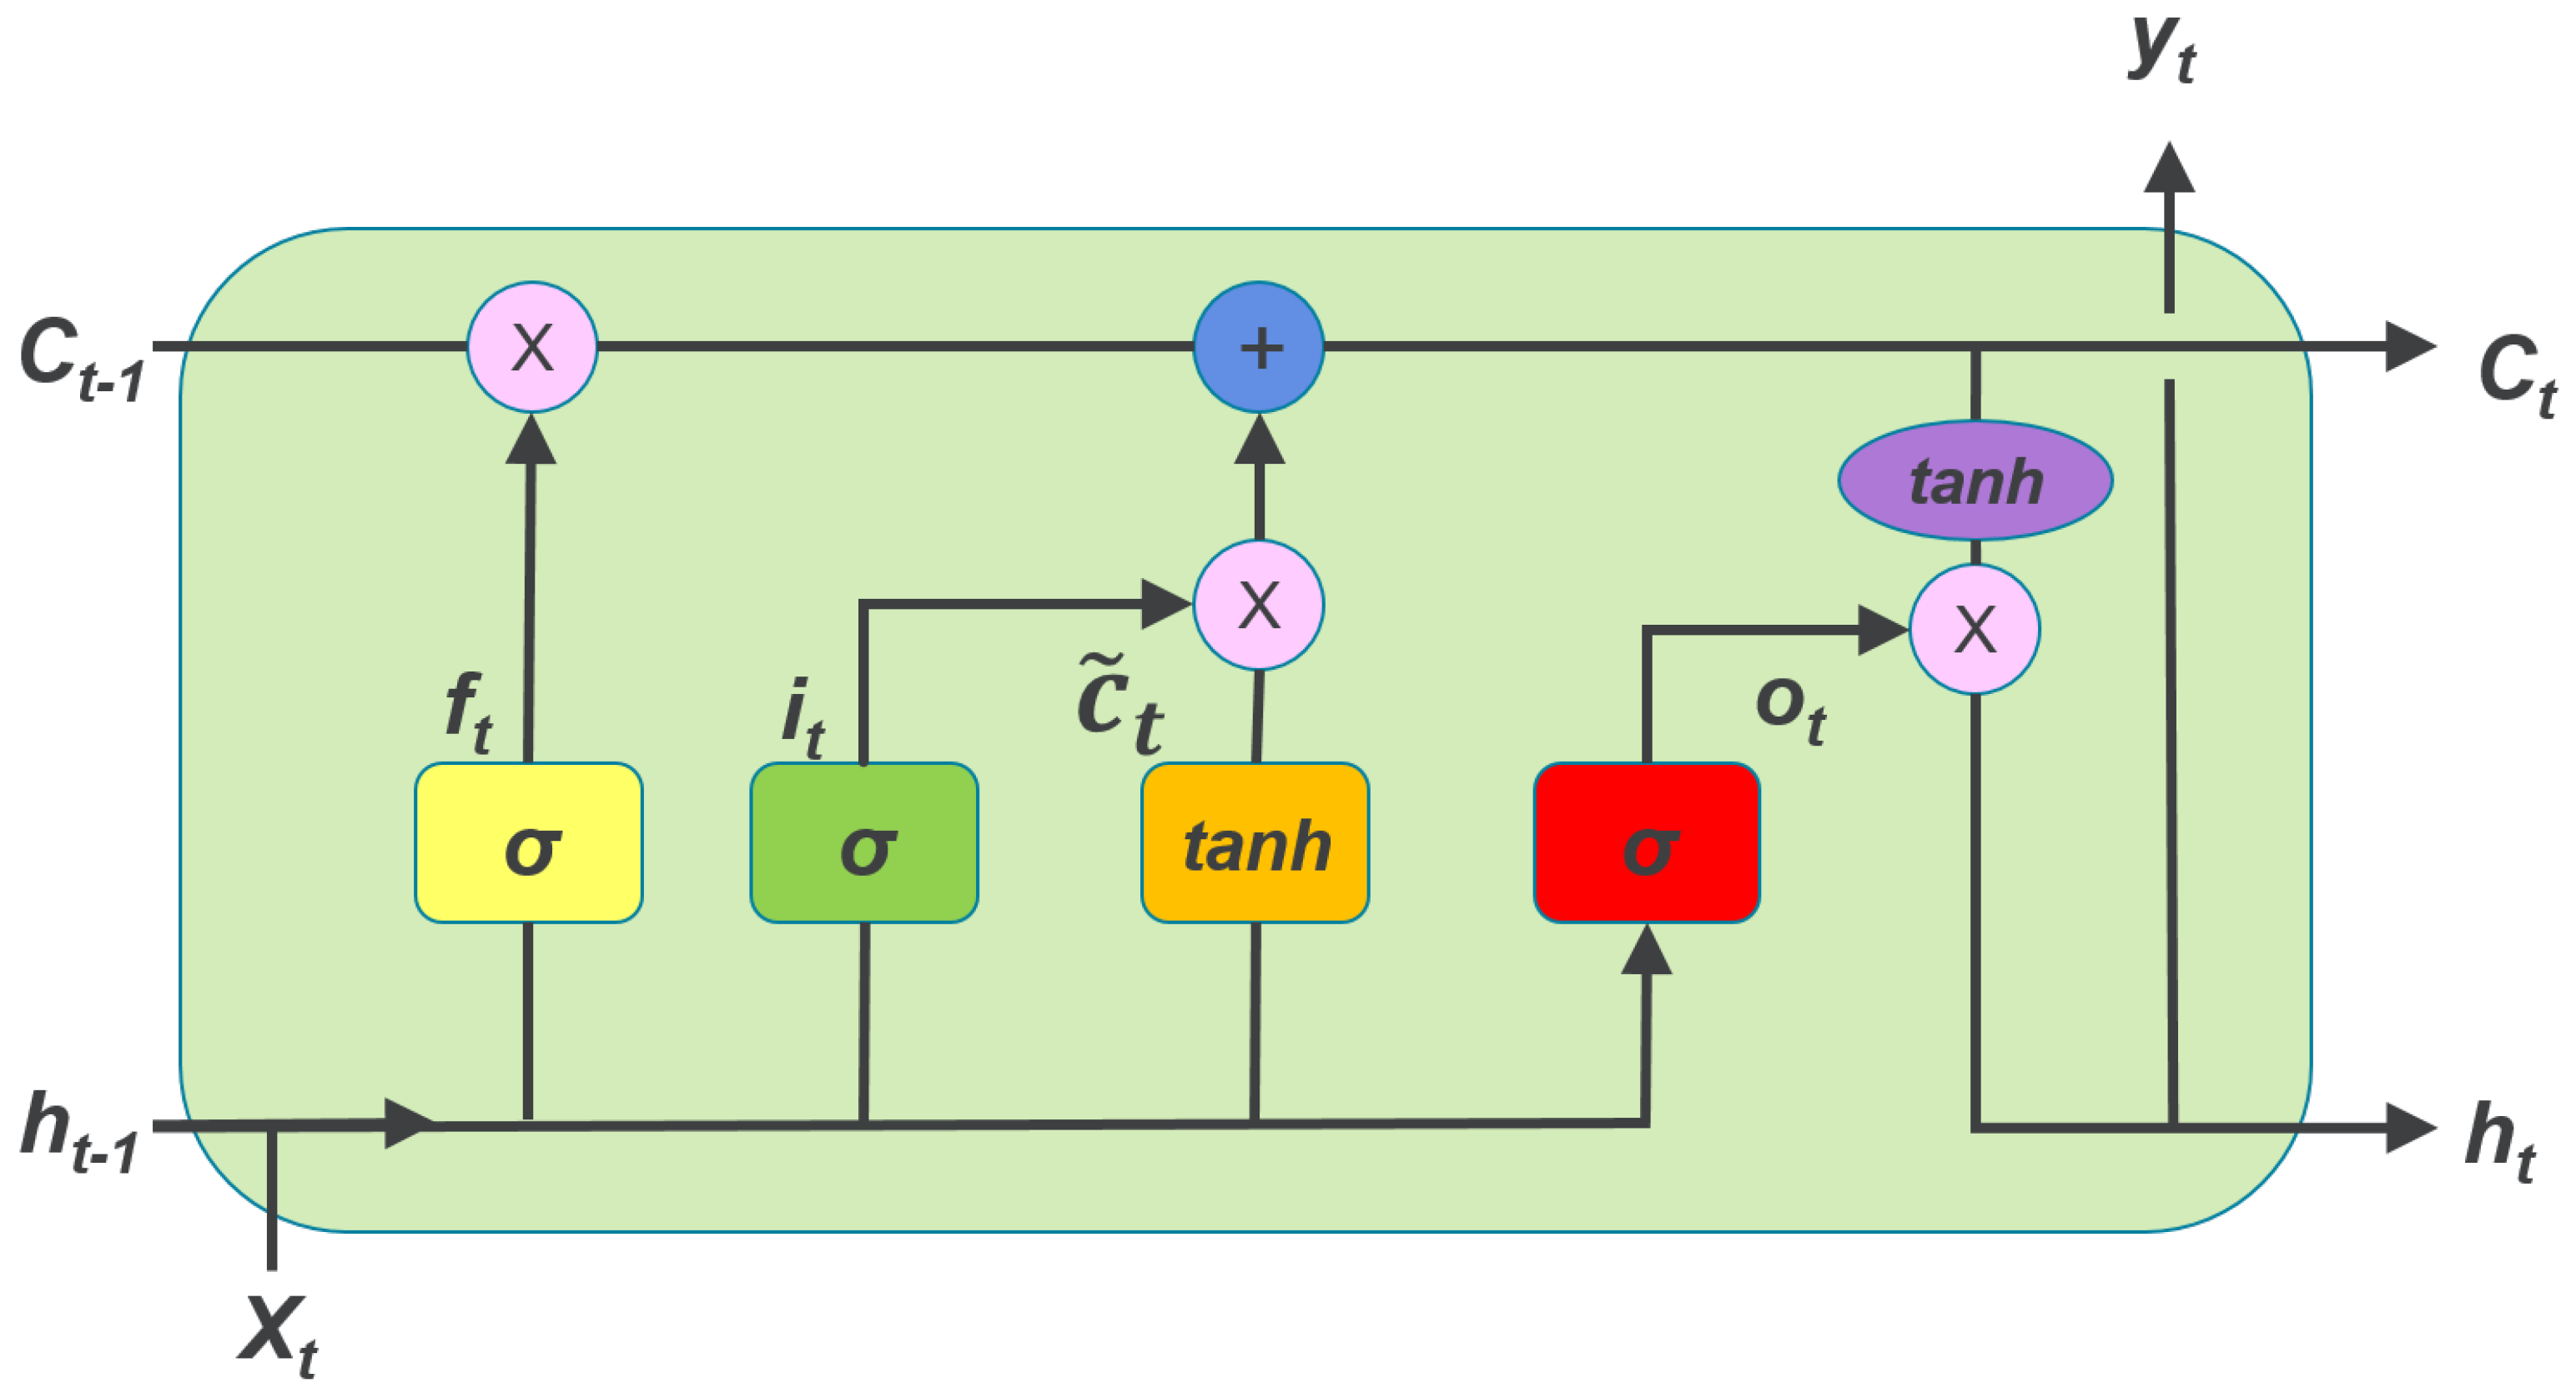

In [24]:
from IPython.display import Image
Image(filename='local/imgs/LSTM2.png', width=1200)

The cells use the principle of cumulative average called **Exponential Weighted Moving Average (EWMA)** originally proposed for a type of units called leaky units. EWMA takes into account more or less information from the past based on a $\beta$ paratemer. The rule is given by: $\mu^{(t)} \leftarrow \beta \mu^{(t-1)} + (1 - \beta)\upsilon^{(t)}$. 

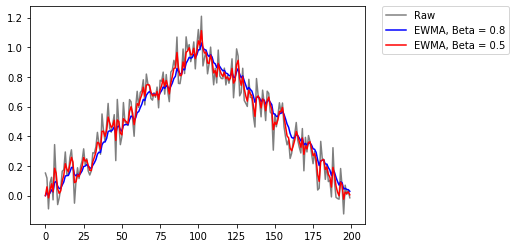

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
# make a hat function, and add noise
x = np.linspace(0,1,100)
x = np.hstack((x,x[::-1]))
x += np.random.normal( loc=0, scale=0.1, size=200 )
plt.plot( x, 'k', alpha=0.5, label='Raw' )
 
Beta1 = 0.8
Beta2 = 0.5
x1 = np.zeros(200)
x2 = np.copy(x1)
for i in range(1,200):
    x1[i] = Beta1*x1[i-1] + (1-Beta1)*x[i]
    x2[i] = Beta2*x2[i-1] + (1-Beta2)*x[i]
# regular EWMA, with bias against trend
plt.plot( x1, 'b', label='EWMA, Beta = 0.8' )
 
# "corrected" (?) EWMA
plt.plot( x2, 'r', label='EWMA, Beta = 0.5' )
 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()
#savefig( 'ewma_correction.png', fmt='png', dpi=100 )

The LSTM network uses the same principle the level of memory or time dependence, but instead of one controling parameter, it define **gates** adjusted during the training phase. 

Every cell LSTM contains three gates (the three $\sigma's$ in the former graph):

- The first step in the LSTM is to decide what information is going to be throwed away from the cell state. This decision is made by a sigmoid layer called the **forget gate layer.** It looks at $h_{t−1}$ and $x_t$, and outputs a number between 0 and 1 for each number in the cell state $C_{t−1}$. A 1 represents “completely keep this” while a 0 represents “completely get rid of this.”

$$f_l^{(t)} = \sigma \left( b_l^f + \sum_j U_{l,j}^f x_j^{(t)} + \sum_j V_{l,j}^f h_j^{(t-1)}\right)$$

- The next step is to decide what new information is going to be stored in the cell state. This has two parts. First, a sigmoid layer called the **input gate layer** decides which values will be updated. Next, a tanh layer creates a vector of new candidate values, $\tilde{C}_t$, that could be added to the state.

$$i_l^{(t)} = \sigma \left( b_l^i + \sum_j U_{l,j}^i x_j^{(t)} + \sum_j V_{l,j}^i h_j^{(t-1)}\right)$$

- Finally, the cell decides what is going to output. This output will be based on the cell state, but will be a filtered version. First, it runs a **output gate layer** which decides what part of the cell state is going to output. Then, the cell state is passed through a tanh function (to push the values to be between −1 and 1) and multiplied it by the output of the gate.

$$o_l^{(t)} = \sigma \left( b_l^o + \sum_j U_{l,j}^o x_j^{(t)} + \sum_j V_{l,j}^o h_j^{(t-1)}\right)$$

Based on these gates, the state of the cell and output of the cell can be calculated as:

$$ c_l^{(t)} = f_l^{(t)}c_l^{(t-1)} + i_l^{(t)}\tanh \left( b_l^c + \sum_j U_{l,j}^c x_j^{(t)} + \sum_j V_{l,j}^c h_j^{(t-1)} \right)$$

$$h_l^{(t)} = \tanh(c_l^{(t)})o_l^{(t)}$$

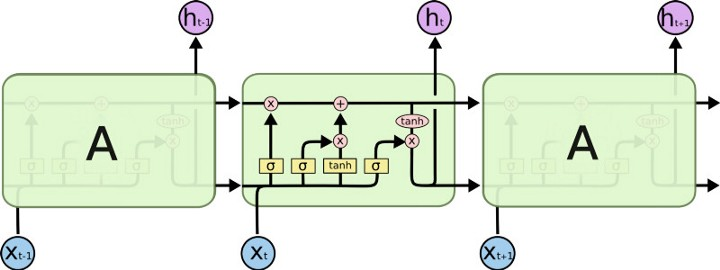

In [4]:
Image(filename='local/imgs/LSTM2.jpeg', width=1200)

In [3]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, SimpleRNN
import math
from sklearn.metrics import mean_squared_error

In [4]:
#Esta celda es por problemas de compatibilidad con la GPU en la última actualización

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
# First, we get the data
dataset = pd.read_csv('local/data/KO_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,20.40,20.50,20.18,20.45,13640800,KO
2006-01-04,20.50,20.54,20.33,20.41,19993200,KO
2006-01-05,20.36,20.56,20.29,20.51,16613400,KO
2006-01-06,20.53,20.78,20.43,20.70,17122800,KO
2006-01-09,20.74,20.84,20.62,20.80,13819800,KO


In [6]:
# Checking for missing values
training_set = dataset[:'2015'].iloc[:,1:2].values
test_set = dataset['2016':].iloc[:,1:2].values
test_set[np.isnan(test_set)] = dataset['High'].max()

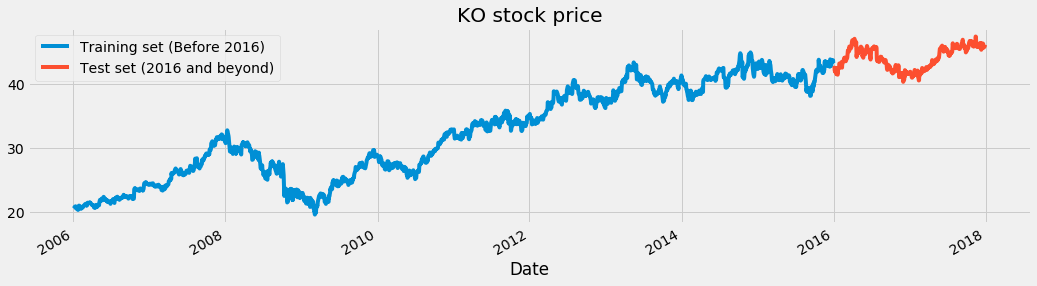

In [7]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2015'].plot(figsize=(16,4),legend=True)
dataset["High"]['2016':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2016)','Test set (2016 and beyond)'])
plt.title('KO stock price')
plt.show()

In [8]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [9]:
from local.lib.DataPreparationRNN import create_dataset
look_back = 10
X_train, y_train = create_dataset(training_set_scaled, look_back)
print(X_train.shape)
print(y_train.shape)

(2507, 10)
(2507,)


In [10]:
# The RNN architecture
model = Sequential()
# First RNN layer with Dropout regularisation
model.add(SimpleRNN(units=50,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 50)                2600      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


Let's remember what a RNN can do:

In [12]:
# Compiling the RNN
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
79/79 [==============================] - 1s 3ms/step - loss: 0.0558
Epoch 2/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0057
Epoch 3/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 4/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 5/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0030
Epoch 6/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0027
Epoch 7/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0024
Epoch 8/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 9/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0025
Epoch 10/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 11/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 12/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 13/50
79/79 [==============================

In [13]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - look_back:].values
inputs[np.isnan(inputs)] = dataset['High'].max()
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)
inputs.shape

(513, 1)

In [14]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(look_back,inputs.shape[0]):
    X_test.append(inputs[i-look_back:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

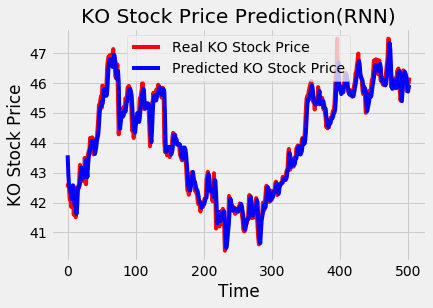

In [15]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(RNN)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [16]:
# Evaluating our model
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.34510828924483167.


Now using a LSTM:

In [17]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

In [18]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [19]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
79/79 [==============================] - 2s 2ms/step - loss: 0.1240
Epoch 2/50
79/79 [==============================] - 0s 2ms/step - loss: 0.0077
Epoch 3/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0056
Epoch 4/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0045
Epoch 5/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 6/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 7/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 8/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 9/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 10/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 11/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 12/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 13/50
79/79 [==============================

In [20]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

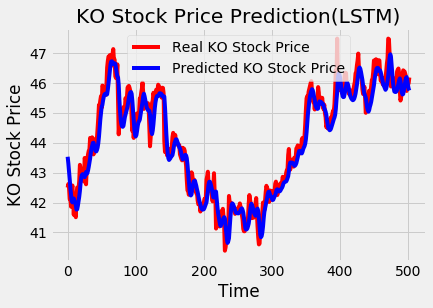

In [21]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(LSTM)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [22]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.4540379895030553.


## Gated Recurrent Units

The GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results. [Source](https://www.kaggle.com/honeysingh/intro-to-recurrent-neural-networks-lstm-gru/notebook)

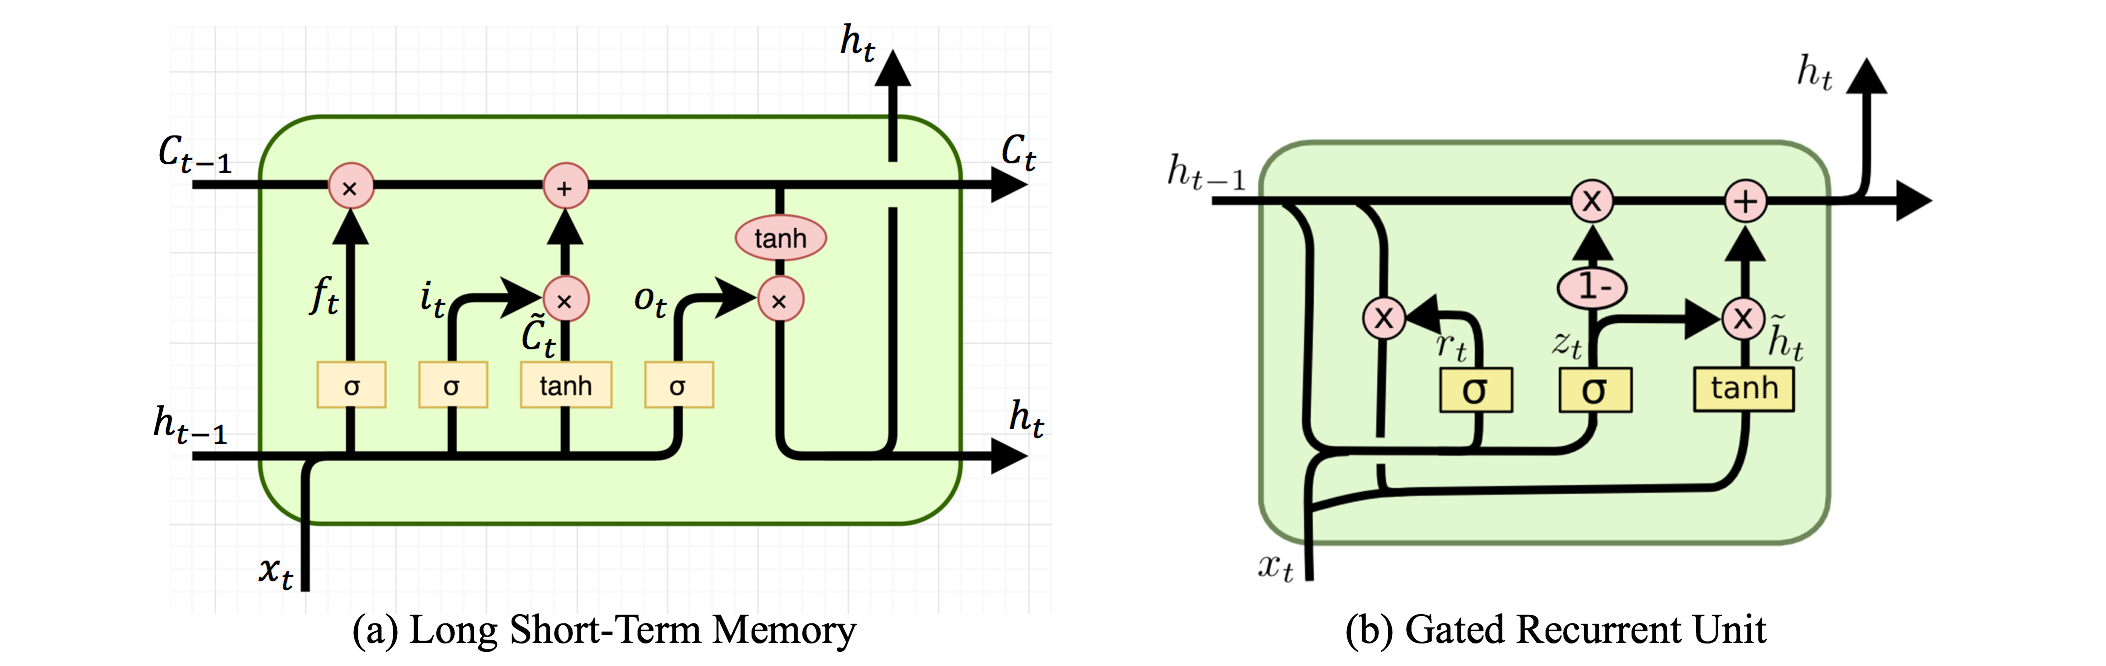

In [25]:
Image(filename='local/imgs/lstmandgru.png', width=1200)

[Source](https://isaacchanghau.github.io/post/lstm-gru-formula/)

$$z_t = \sigma(x_t U^z + h_{t-1} V^z)$$

$$r_t = \sigma(x_t U^r + h_{t-1} V^r)$$

$$\tilde{h}_t = \tanh(x_t U^h +(r_t h^{t−1}) W^h)$$

$$ h_t = (1-z_t)h_{t-1} + z_t \tilde{h}_t$$

Here $r$ is a reset gate, and $z$ is an update gate. Intuitively, the reset gate determines how to combine the new input with the previous memory, and the update gate defines how much of the previous memory to keep around. If set the reset to all 1’s and update gate to all 0’s, it will arrive at the vanilla RNN model.

In [26]:
# The GRU architecture
regressor2 = Sequential()
# First GRU layer with Dropout regularisation
regressor2.add(GRU(units=50, input_shape=(X_train.shape[1],1)))
regressor2.add(Dropout(0.3))
# The output layer
regressor2.add(Dense(units=1))

In [27]:
regressor2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 50)                7950      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 8,001
Trainable params: 8,001
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compiling the RNN
regressor2.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
regressor2.fit(X_train.reshape(X_train.shape[0],look_back,1),y_train,epochs=50,batch_size=32)

Epoch 1/50
79/79 [==============================] - 1s 2ms/step - loss: 0.1361
Epoch 2/50
79/79 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 3/50
79/79 [==============================] - 0s 2ms/step - loss: 0.0044
Epoch 4/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0039
Epoch 5/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 6/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0035
Epoch 7/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 8/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 9/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0033
Epoch 10/50
79/79 [==============================] - 0s 3ms/step - loss: 0.0032
Epoch 11/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0029
Epoch 12/50
79/79 [==============================] - 0s 4ms/step - loss: 0.0027
Epoch 13/50
79/79 [==============================

**Note** that the every epoch runs a little bit faster than in the LSTM model.

In [29]:
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

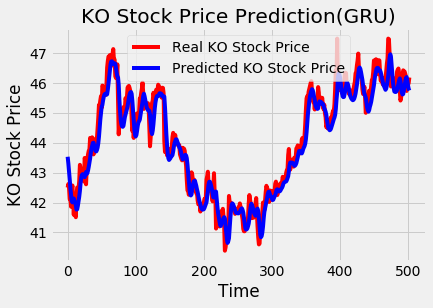

In [30]:
# Visualizing the results
plt.plot(test_set, color='red',label='Real KO Stock Price')
plt.plot(predicted_stock_price, color='blue',label='Predicted KO Stock Price')
plt.title('KO Stock Price Prediction(GRU)')
plt.xlabel('Time')
plt.ylabel('KO Stock Price')
plt.legend()
plt.show()

In [31]:
# Evaluating our model
rmse = math.sqrt(mean_squared_error(test_set, predicted_stock_price))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 0.4540379895030553.


Interesting readings:

 - Understanding LSTM Networks. http://colah.github.io/posts/2015-08-Understanding-LSTMs/